**Chatbot with LangGraph (No tools)**

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv

load_dotenv()

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=memory)

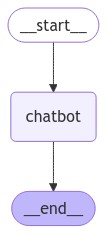

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
config = {"configurable": {"thread_id": "1"}}

print(graph.invoke({"messages": [("user", "What happened in the 2024 olymipcs?")]}, config=config)['messages'][1].content)

I apologize, but the 2024 Olympics have not yet taken place. The 2024 Summer Olympics are scheduled to take place in Paris, France, from July 26 to August 11, 2024, and the 2024 Winter Olympics are scheduled to take place in Milan-Cortina, Italy, from February 6 to 22, 2026.

As the events have not yet occurred, there is no information available on the results, medal count, or any other details related to the 2024 Olympics. I'll be happy to provide information on the Olympics once the events take place.


In [12]:
print(next(memory.list(config)).checkpoint['channel_values']['messages'][-1].content)

I apologize, but the 2024 Olympics have not yet taken place. The 2024 Summer Olympics are scheduled to take place in Paris, France, from July 26 to August 11, 2024, and the 2024 Winter Olympics are scheduled to take place in Milan-Cortina, Italy, from February 6 to 22, 2026.

As the events have not yet occurred, there is no information available on the results, medal count, or any other details related to the 2024 Olympics. I'll be happy to provide information on the Olympics once the events take place.


**Chatbot with LangGraph (With Tools)**

In [13]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode,tools_condition
from dotenv import load_dotenv

load_dotenv()

# Tools to use
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# Instantiating the tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=1000)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=1000)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

tools = [arxiv_tool, wiki_tool]

llm_with_tools=llm.bind_tools(tools=tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")

graph = graph_builder.compile()

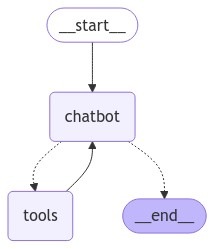

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [19]:
user_input="Bye Bye"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Bye Bye
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_ap9q)
 Call ID: call_ap9q
  Args:
    query: Goodbye


c:\Users\okwy_\AppData\Local\Programs\Python\Python311\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\okwy_\AppData\Local\Programs\Python\Python311\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_qcfj)
 Call ID: call_qcfj
  Args:
    query: Goodbye
================================= Tool Message =================================
Name: arxiv

Published: 1999-04-18
Title: Gravity waves goodbye
Authors: J. P. Zibin, Douglas Scott, Martin White
Summary: The detection of a stochastic background of long-wavelength gravitational
waves (tensors) in the cosmic microwave background (CMB) anisotropy would be an
invaluable probe of the high energy physics of the early universe.
Unfortunately a combination of factors now makes such a detection seem
unlikely: the vast majority of the CMB signal appears to come from density
perturbations (scalars) - detailed fits to current observations indicate a
tensor-to-scalar quadrupole ratio of T/S < 0.5 for the